# 04 - Feature Engineering for Thalassemia Analysis (Fixed)

## Objectives
- Load cleaned Thalassemia data
- Create clinically relevant features
- Analyze feature distributions
- Apply appropriate transformations
- Prepare data for machine learning

## Clinical Context
Key Thalassemia indicators:
- **Microcytosis**: MCV < 80 fL
- **Hypochromia**: MCH < 27 pg
- **Mentzer Index**: MCV/RBC < 13
- **HbA2 levels**: Normal 1.5-3.5%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import os

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("Libraries imported successfully!")
current_dir = os.getcwd()
current_dir

Libraries imported successfully!


'/Users/nour/Desktop/DiplomaProjects/ThalassemiaPredictor/thalassemia_predictor/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/Users/nour/Desktop/DiplomaProjects/ThalassemiaPredictor/thalassemia_predictor'

In [3]:
# Load cleaned data
try:
    X_train = pd.read_csv('outputs/datasets/cleaned/X_train.csv')
    X_test = pd.read_csv('outputs/datasets/cleaned/X_test.csv')
    y_train = pd.read_csv('outputs/datasets/cleaned/y_train.csv').squeeze()
    y_test = pd.read_csv('outputs/datasets/cleaned/y_test.csv').squeeze()
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Features: {X_train.columns.tolist()}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please run the data cleaning notebook first.")

Training set: (162, 11)
Test set: (41, 11)
Features: ['sex', 'hb', 'pcv', 'rbc', 'mcv', 'mch', 'mchc', 'rdw', 'hba', 'hba2', 'hbf']


## Clinical Feature Engineering

In [4]:
def create_thalassemia_features(df):
    """Create clinically relevant features for Thalassemia diagnosis"""
    df_eng = df.copy()
    
    # 1. Mentzer Index (MCV/RBC) - Key Thalassemia indicator
    if 'mcv' in df.columns and 'rbc' in df.columns:
        df_eng['mentzer_index'] = df_eng['mcv'] / df_eng['rbc']
        df_eng['mentzer_thal_indicator'] = (df_eng['mentzer_index'] < 13).astype(int)
    
    # 2. RBC/Hb ratio (elevated in Thalassemia)
    if 'rbc' in df.columns and 'hb' in df.columns:
        df_eng['rbc_hb_ratio'] = df_eng['rbc'] / df_eng['hb']
    
    # 3. Clinical indicators
    if 'mcv' in df.columns:
        df_eng['microcytosis'] = (df_eng['mcv'] < 80).astype(int)
    
    if 'mch' in df.columns:
        df_eng['hypochromia'] = (df_eng['mch'] < 27).astype(int)
    
    # 4. HbA2 analysis
    if 'hba2' in df.columns:
        df_eng['hba2_elevated'] = (df_eng['hba2'] > 3.5).astype(int)
        df_eng['hba2_normal'] = ((df_eng['hba2'] >= 1.5) & (df_eng['hba2'] <= 3.5)).astype(int)
    
    # 5. Additional ratios
    if 'rdw' in df.columns and 'mcv' in df.columns:
        df_eng['rdw_mcv_ratio'] = df_eng['rdw'] / df_eng['mcv']
    
    if 'hba' in df.columns and 'hba2' in df.columns:
        df_eng['hba_hba2_ratio'] = df_eng['hba'] / (df_eng['hba2'] + 0.001)
    
    return df_eng

# Apply clinical feature engineering
X_train_eng = create_thalassemia_features(X_train)
X_test_eng = create_thalassemia_features(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_eng.shape[1]}")
print(f"New features added: {X_train_eng.shape[1] - X_train.shape[1]}")

new_features = [col for col in X_train_eng.columns if col not in X_train.columns]
print(f"\nNew clinical features: {new_features}")

Original features: 11
Engineered features: 20
New features added: 9

New clinical features: ['mentzer_index', 'mentzer_thal_indicator', 'rbc_hb_ratio', 'microcytosis', 'hypochromia', 'hba2_elevated', 'hba2_normal', 'rdw_mcv_ratio', 'hba_hba2_ratio']


## Feature Distribution Analysis

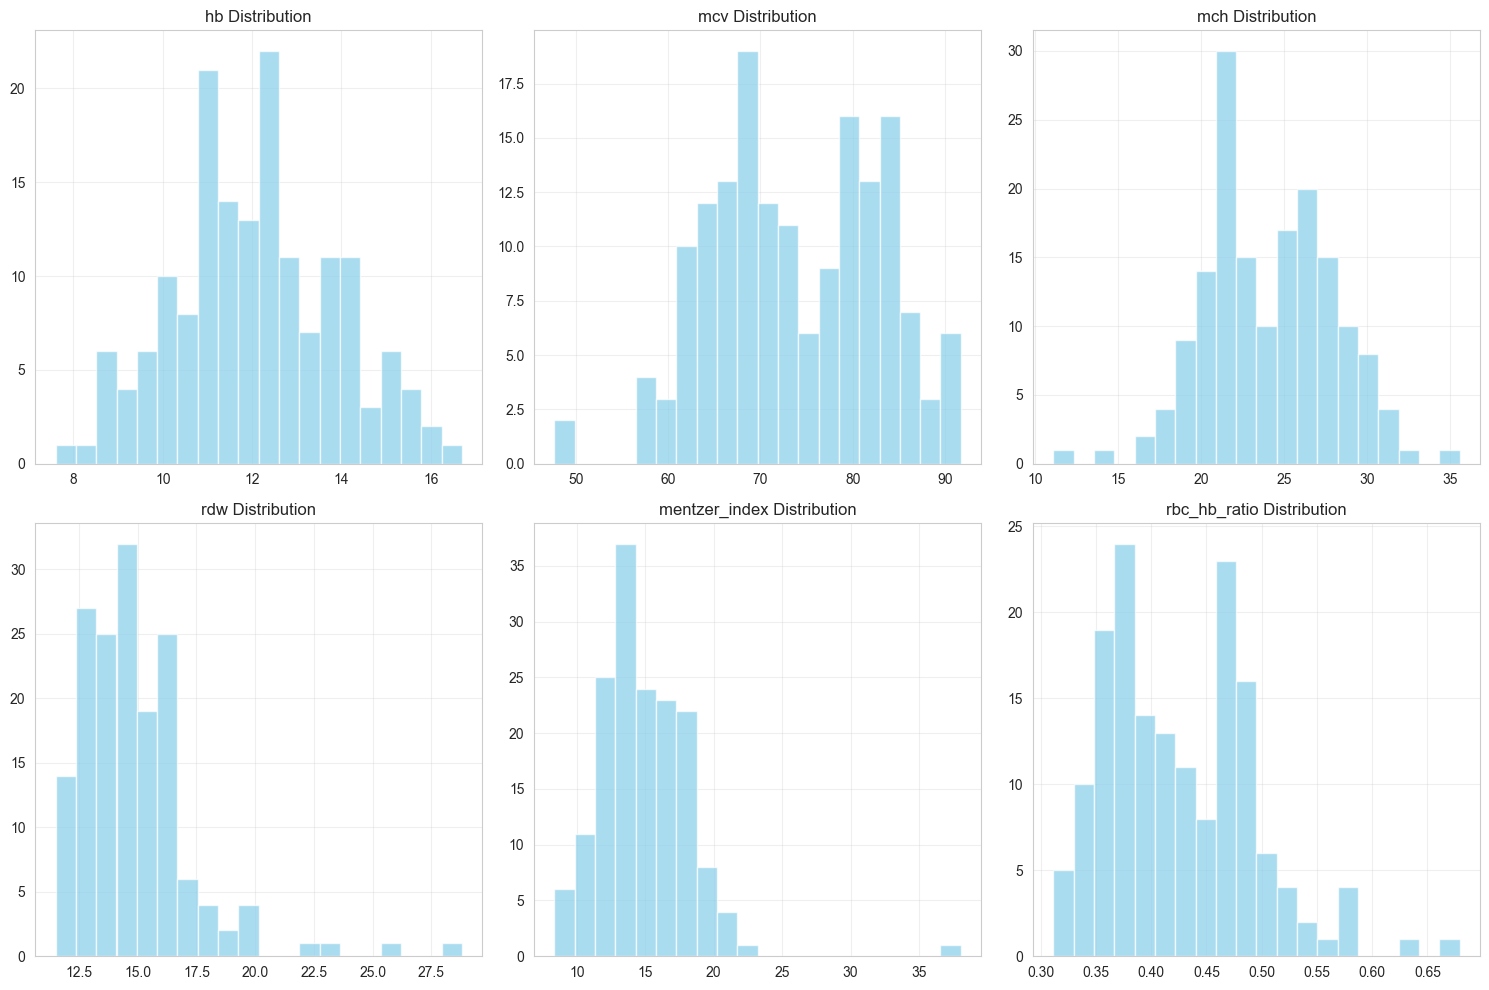


Feature Statistics:
               hb         mcv         mch         rdw  mentzer_index  \
count  162.000000  162.000000  162.000000  162.000000     162.000000   
mean    12.063580   73.808191   24.088272   14.904452      14.903461   
std      1.805504    9.102936    3.879959    2.473093       3.342209   
min      7.600000   47.700000   11.100000   11.500000       8.358974   
25%     10.900000   67.125000   21.225000   13.225000      12.766631   
50%     12.000000   73.200000   24.000000   14.700000      14.446114   
75%     13.300000   81.425000   26.800000   16.000000      16.867445   
max     16.700000   91.700000   35.600000   28.800000      38.049793   

       rbc_hb_ratio  
count    162.000000  
mean       0.425965  
std        0.065488  
min        0.311364  
25%        0.374202  
50%        0.417206  
75%        0.469937  
max        0.679167  


In [5]:
# Analyze key feature distributions
key_features = ['hb', 'mcv', 'mch', 'rdw', 'mentzer_index', 'rbc_hb_ratio']
available_key_features = [col for col in key_features if col in X_train_eng.columns]

if len(available_key_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(available_key_features[:6]):
        if i < len(axes):
            X_train_eng[feature].hist(bins=20, ax=axes[i], alpha=0.7, color='skyblue')
            axes[i].set_title(f'{feature} Distribution')
            axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(available_key_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Statistics:")
    print(X_train_eng[available_key_features].describe())
else:
    print("No key features available for analysis.")

## Outlier Detection

In [6]:
# Simple outlier detection using IQR method
def detect_outliers(df, columns):
    """Detect outliers using IQR method"""
    outlier_info = {}
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(df)) * 100
            
            outlier_info[col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    return outlier_info

# Detect outliers in key hematological parameters
hematological_features = ['hb', 'mcv', 'mch', 'rdw', 'hba2']
available_hema_features = [col for col in hematological_features if col in X_train_eng.columns]

outlier_results = detect_outliers(X_train_eng, available_hema_features)

print("Outlier Analysis Results:")
print("=" * 50)
for feature, info in outlier_results.items():
    print(f"{feature}:")
    print(f"  Outliers: {info['count']} ({info['percentage']:.1f}%)")
    print(f"  Normal range: {info['lower_bound']:.2f} - {info['upper_bound']:.2f}")
    print()

Outlier Analysis Results:
hb:
  Outliers: 0 (0.0%)
  Normal range: 7.30 - 16.90

mcv:
  Outliers: 0 (0.0%)
  Normal range: 45.68 - 102.88

mch:
  Outliers: 2 (1.2%)
  Normal range: 12.86 - 35.16

rdw:
  Outliers: 4 (2.5%)
  Normal range: 9.06 - 20.16

hba2:
  Outliers: 12 (7.4%)
  Normal range: 2.20 - 3.00



## Feature Correlation Analysis

In [7]:
# Correlation analysis for feature selection
correlation_matrix = X_train_eng.corr()

# Find highly correlated feature pairs
def find_correlated_features(corr_matrix, threshold=0.8):
    """Find pairs of highly correlated features"""
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return high_corr_pairs

high_corr_features = find_correlated_features(correlation_matrix, threshold=0.8)

print("Highly Correlated Feature Pairs (|r| > 0.8):")
print("=" * 50)
for pair in high_corr_features:
    print(f"{pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")

if not high_corr_features:
    print("No highly correlated feature pairs found.")

Highly Correlated Feature Pairs (|r| > 0.8):
hb <-> pcv: 0.882
rbc <-> mentzer_index: -0.812
mcv <-> mch: 0.892
mcv <-> rbc_hb_ratio: -0.923
mcv <-> rdw_mcv_ratio: -0.825
mch <-> rbc_hb_ratio: -0.914
rdw <-> rdw_mcv_ratio: 0.941
rbc_hb_ratio <-> rdw_mcv_ratio: 0.824
hba2_normal <-> hba_hba2_ratio: -0.812


## Feature Importance Analysis

Feature Importance (ANOVA F-test):
          feature     score   p_value
9            hba2  2.322729  0.129470
10            hbf  2.304558  0.130968
15    hypochromia  2.206015  0.139441
4             mcv  1.774327  0.184742
11  mentzer_index  1.622770  0.204553
8             hba  1.222645  0.270502
14   microcytosis  0.967314  0.326836
18  rdw_mcv_ratio  0.817040  0.367406
17    hba2_normal  0.749255  0.388008
6            mchc  0.724581  0.395918


/Users/nour/Desktop/DiplomaProjects/ThalassemiaPredictor/thalassemia_predictor/.venv/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nour/Desktop/DiplomaProjects/ThalassemiaPredictor/thalassemia_predictor/.venv/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


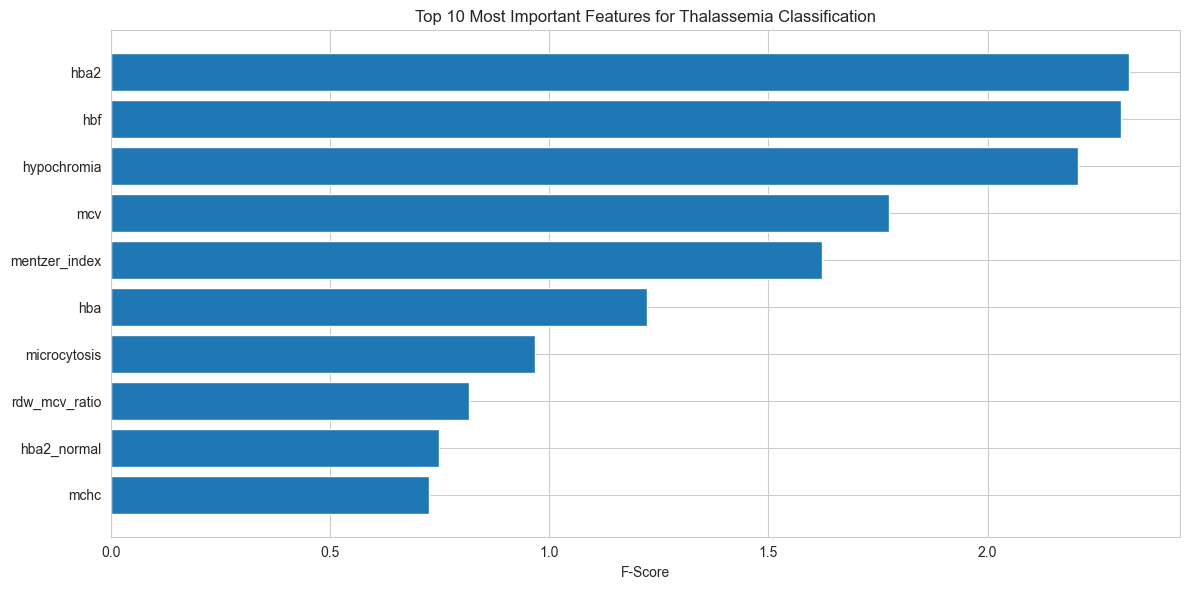

In [8]:
# Encode target for analysis
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Feature importance using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_eng, y_train_encoded)

# Get feature scores
feature_scores = pd.DataFrame({
    'feature': X_train_eng.columns,
    'score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('score', ascending=False)

print("Feature Importance (ANOVA F-test):")
print("=" * 50)
print(feature_scores.head(10))

# Plot top 10 features
plt.figure(figsize=(12, 6))
top_features = feature_scores.head(10)
plt.barh(range(len(top_features)), top_features['score'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('F-Score')
plt.title('Top 10 Most Important Features for Thalassemia Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Feature Engineering Summary and Recommendations

In [9]:
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Training samples: {X_train_eng.shape[0]}")
print(f"   - Original features: {X_train.shape[1]}")
print(f"   - Engineered features: {X_train_eng.shape[1]}")
print(f"   - New features added: {X_train_eng.shape[1] - X_train.shape[1]}")

print(f"\n2. CLINICAL FEATURES CREATED:")
clinical_features = [col for col in X_train_eng.columns if col not in X_train.columns]
for feature in clinical_features:
    print(f"   - {feature}")

print(f"\n3. TOP 5 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(feature_scores.head(5).iterrows()):
    print(f"   {i+1}. {row['feature']} (F-score: {row['score']:.2f})")

print(f"\n4. CLINICAL VALIDATION:")
print(f"   - Mentzer Index created: {'mentzer_index' in clinical_features}")
print(f"   - Microcytosis indicator: {'microcytosis' in clinical_features}")
print(f"   - Hypochromia indicator: {'hypochromia' in clinical_features}")
print(f"   - HbA2 analysis: {'hba2_elevated' in clinical_features}")

print(f"\n5. RECOMMENDATIONS:")
print(f"   - Focus on top-scoring clinical features for modeling")
print(f"   - Consider feature interactions (e.g., MCV × RBC)")
print(f"   - Validate clinical thresholds with domain experts")
print(f"   - Test ensemble methods to capture feature relationships")

print("\n" + "=" * 60)

FEATURE ENGINEERING SUMMARY

1. DATASET OVERVIEW:
   - Training samples: 162
   - Original features: 11
   - Engineered features: 20
   - New features added: 9

2. CLINICAL FEATURES CREATED:
   - mentzer_index
   - mentzer_thal_indicator
   - rbc_hb_ratio
   - microcytosis
   - hypochromia
   - hba2_elevated
   - hba2_normal
   - rdw_mcv_ratio
   - hba_hba2_ratio

3. TOP 5 MOST IMPORTANT FEATURES:
   1. hba2 (F-score: 2.32)
   2. hbf (F-score: 2.30)
   3. hypochromia (F-score: 2.21)
   4. mcv (F-score: 1.77)
   5. mentzer_index (F-score: 1.62)

4. CLINICAL VALIDATION:
   - Mentzer Index created: True
   - Microcytosis indicator: True
   - Hypochromia indicator: True
   - HbA2 analysis: True

5. RECOMMENDATIONS:
   - Focus on top-scoring clinical features for modeling
   - Consider feature interactions (e.g., MCV × RBC)
   - Validate clinical thresholds with domain experts
   - Test ensemble methods to capture feature relationships



## Save Engineered Features

In [10]:
# Create output directory
output_dir = 'outputs/datasets/engineered/'
os.makedirs(output_dir, exist_ok=True)

# Save engineered datasets
try:
    X_train_eng.to_csv(f'{output_dir}X_train_engineered.csv', index=False)
    X_test_eng.to_csv(f'{output_dir}X_test_engineered.csv', index=False)
    y_train.to_csv(f'{output_dir}y_train.csv', index=False)
    y_test.to_csv(f'{output_dir}y_test.csv', index=False)
    
    # Save feature importance results
    feature_scores.to_csv(f'{output_dir}feature_importance.csv', index=False)
    
    print(f"Engineered features saved to: {output_dir}")
    print("Files created:")
    print("- X_train_engineered.csv")
    print("- X_test_engineered.csv")
    print("- y_train.csv")
    print("- y_test.csv")
    print("- feature_importance.csv")
    
except Exception as e:
    print(f"Error saving files: {e}")

print("\nFeature engineering completed successfully!")
print("Data is ready for machine learning model development.")

Engineered features saved to: outputs/datasets/engineered/
Files created:
- X_train_engineered.csv
- X_test_engineered.csv
- y_train.csv
- y_test.csv
- feature_importance.csv

Feature engineering completed successfully!
Data is ready for machine learning model development.


## Clinical Feature Validation

In [11]:
# Validate clinical features by comparing distributions between phenotypes
if 'mentzer_index' in X_train_eng.columns:
    train_with_target = X_train_eng.copy()
    train_with_target['phenotype'] = y_train
    
    print("Clinical Feature Validation:")
    print("=" * 40)
    
    # Mentzer Index validation
    mentzer_by_phenotype = train_with_target.groupby('phenotype')['mentzer_index'].agg(['mean', 'std', 'count'])
    print("\nMentzer Index by Phenotype:")
    print(mentzer_by_phenotype)
    
    # Count of Mentzer Index < 13 by phenotype
    if 'mentzer_thal_indicator' in train_with_target.columns:
        mentzer_indicator_counts = train_with_target.groupby('phenotype')['mentzer_thal_indicator'].sum()
        print("\nMentzer Index < 13 (Thalassemia indicator):")
        print(mentzer_indicator_counts)
    
    # Microcytosis prevalence
    if 'microcytosis' in train_with_target.columns:
        microcytosis_counts = train_with_target.groupby('phenotype')['microcytosis'].sum()
        print("\nMicrocytosis (MCV < 80) prevalence:")
        print(microcytosis_counts)
    
    # HbA2 elevation
    if 'hba2_elevated' in train_with_target.columns:
        hba2_elevated_counts = train_with_target.groupby('phenotype')['hba2_elevated'].sum()
        print("\nHbA2 elevation (> 3.5%) prevalence:")
        print(hba2_elevated_counts)

print("\nFeature engineering analysis completed!")
print("The engineered dataset is ready for machine learning model training.")

Clinical Feature Validation:

Mentzer Index by Phenotype:
                    mean       std  count
phenotype                                
alpha carrier  15.107330  3.504506    118
normal         14.356721  2.826074     44

Mentzer Index < 13 (Thalassemia indicator):
phenotype
alpha carrier    33
normal           15
Name: mentzer_thal_indicator, dtype: int64

Microcytosis (MCV < 80) prevalence:
phenotype
alpha carrier    79
normal           33
Name: microcytosis, dtype: int64

HbA2 elevation (> 3.5%) prevalence:
phenotype
alpha carrier    0
normal           0
Name: hba2_elevated, dtype: int64

Feature engineering analysis completed!
The engineered dataset is ready for machine learning model training.
